In [ ]:
"""
Colab Notebook Set Up

Use this cell to upload your kaggle.json file as well as the `download_data.sh`
and `preprocess.py` scripts.
"""

from google.colab import files, drive
import os

# Mount google drive
drive.mount('/content/drive')

# Upload files
kaggle = files.upload()
data_script = files.upload()
preprocess_script = files.upload()
config = files.upload()

# Verify uploads
for file in ["kaggle.json", "download_data.sh", "preprocess.py", "ViT-oct.yaml"]:
    assert file in os.listdir(), f"Make sure you upload the {file} file"

# Shell commands (files)
!mkdir -p ~/.kaggle/ data/ models/ config/ scripts/ net/ figures/ results/
!mv kaggle.json ~/.kaggle/
!mv download_data.sh preprocess.py scripts/
!mv "ViT-oct.yaml" config/
!chmod 600 ~/.kaggle/kaggle.json
!chmod +x scripts/download_data.sh scripts/preprocess.py
!sed -i -e 's/\r$//' scripts/download_data.sh
!pip install -q kaggle pretrainedmodels rich
!touch net/__init__.py net/train.py net/utils.py

# Run shell commands
!scripts/download_data.sh
!python scripts/preprocess.py --config "config/ViT-oct.yaml" --kw batch-size=64

In [ ]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

%tensorboard --logdir logs

## Finetuning InceptionV3 for Retinal OCT Images

### Context

- Retinal Optical Coherence Tomography (OCT) is an imaging technique used to
  capture high-res cross sections of the retina
- ~84, 495 OCT Images in total

### Content

- Images in JPEG format with 3 channels, i.e., RGB
- 4 categories: CNV, DME, DRUSEN, NORMAL

### This Notebook

- Fine-tune InceptionV3 by training the last, linear layer on the new data
- The images are pre-processed by running the forward pass through the
  InceptionV3 network and saving the output of the last pooling layer
  (2048-dimensional vector) to disk.
  - These feature vectors are then used to train a single-layer linear
    classifier on the new data

In [4]:
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch import nn, optim
import torch

from datetime import datetime
from tqdm.auto import tqdm
from rich import print
from glob import glob

import sys; sys.path.append(".")
from net import train, utils

import numpy as np
import copy
import yaml
import os
import re


config = "config/ViT-oct.yaml"
with open(config, 'r') as f:
    config = yaml.safe_load(f)

In [5]:
class FeatureDataset(Dataset):
    """
    Custom dataset to load InceptionV3 features for fine-tuning
    """

    def __init__(self, feature_dir):
        self.files = sorted(glob(f"{feature_dir}/FL*.npy"), key=self._extract_idx)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        label, feature = np.load(self.files[idx], allow_pickle=True)
        return torch.from_numpy(feature), torch.from_numpy(label)

    def _extract_idx(self, filename):
        """Extract batch index from filename"""
        match = re.search(r"(\d+)\.npy$", filename)
        match = int(match.group(1)) if match else -1
        if match == -1:
            raise ValueError(f"Invalid filename {filename}")
        return match


# Create datasets
data = {
    "train": FeatureDataset(config["features"]["train"]),
    "test": FeatureDataset(config["features"]["test"]),
    "val": FeatureDataset(config["features"]["val"])
}

# Create dataloaders
batch_size = 1024
dataloaders = {
    "train": DataLoader(data["train"], batch_size=batch_size, shuffle=True),
    "test": DataLoader(data["test"], batch_size=batch_size, shuffle=False),
    "val": DataLoader(data["val"], batch_size=batch_size, shuffle=False)
}

In [13]:
class FineTuned(nn.Module):
    """Fine-tuned output layer for InceptionV3"""

    def __init__(self, config):
        super(FineTuned, self).__init__()

        self.clf = nn.Linear(config['embed-dim'], config['num-classes'])

    def forward(self, x):
        x = self.clf(x)
        return x
    
model = FineTuned(config)
model.to(train.device())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["lr"])
# optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)

In [14]:
# Initialize training and logging
timestamp = datetime.now().strftime("%m%d_%H%M%S")
writer = SummaryWriter(f"logs/ViT/oct-{timestamp}")
EPOCH = 0

In [18]:
num_epochs = 100

model, history = train.train_model(
    model, dataloaders, criterion, optimizer, num_epochs, EPOCH, writer,
    is_inception=False
)

EPOCH += num_epochs

torch.save(model.state_dict(), f"models/oct-preprocess-{timestamp}.pth")

Epoch 31/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1626 Acc: 0.9404


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4847 Acc: 0.7500

Epoch 32/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1588 Acc: 0.9422


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4859 Acc: 0.7500

Epoch 33/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1558 Acc: 0.9430


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4670 Acc: 0.7500

Epoch 34/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1526 Acc: 0.9438


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4713 Acc: 0.7500

Epoch 35/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1497 Acc: 0.9443


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4907 Acc: 0.7500

Epoch 36/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1468 Acc: 0.9455


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4650 Acc: 0.7500

Epoch 37/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1444 Acc: 0.9463


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4909 Acc: 0.7500

Epoch 38/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1425 Acc: 0.9477


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4640 Acc: 0.7500

Epoch 39/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1405 Acc: 0.9480


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4792 Acc: 0.7500

Epoch 40/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1385 Acc: 0.9480


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4836 Acc: 0.7500

Epoch 41/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1371 Acc: 0.9494


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4737 Acc: 0.7500

Epoch 42/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1341 Acc: 0.9498


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4946 Acc: 0.7500

Epoch 43/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1324 Acc: 0.9508


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4582 Acc: 0.7500

Epoch 44/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1309 Acc: 0.9523


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4807 Acc: 0.7500

Epoch 45/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1294 Acc: 0.9518


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4787 Acc: 0.7500

Epoch 46/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1279 Acc: 0.9537


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4640 Acc: 0.7500

Epoch 47/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1264 Acc: 0.9531


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4697 Acc: 0.7500

Epoch 48/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1250 Acc: 0.9535


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4712 Acc: 0.7500

Epoch 49/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1237 Acc: 0.9545


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4636 Acc: 0.7500

Epoch 50/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1224 Acc: 0.9547


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4666 Acc: 0.7500

Epoch 51/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1212 Acc: 0.9555


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4812 Acc: 0.7500

Epoch 52/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1204 Acc: 0.9559


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4736 Acc: 0.7500

Epoch 53/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1192 Acc: 0.9568


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4569 Acc: 0.7500

Epoch 54/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1181 Acc: 0.9563


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4635 Acc: 0.7500

Epoch 55/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1175 Acc: 0.9570


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4815 Acc: 0.7500

Epoch 56/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1171 Acc: 0.9572


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4495 Acc: 0.7500

Epoch 57/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1161 Acc: 0.9588


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4752 Acc: 0.7500

Epoch 58/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1156 Acc: 0.9580


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4504 Acc: 0.7500

Epoch 59/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1139 Acc: 0.9586


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4973 Acc: 0.7500

Epoch 60/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1126 Acc: 0.9584


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4338 Acc: 0.7500

Epoch 61/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1114 Acc: 0.9600


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4812 Acc: 0.7500

Epoch 62/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1109 Acc: 0.9602


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4487 Acc: 0.7500

Epoch 63/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1096 Acc: 0.9619


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4744 Acc: 0.7500

Epoch 64/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1085 Acc: 0.9621


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4355 Acc: 0.7500

Epoch 65/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1076 Acc: 0.9613


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4772 Acc: 0.7500

Epoch 66/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1072 Acc: 0.9617


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4469 Acc: 0.7500

Epoch 67/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1062 Acc: 0.9621


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4488 Acc: 0.7500

Epoch 68/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1055 Acc: 0.9635


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4812 Acc: 0.7500

Epoch 69/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1052 Acc: 0.9627


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4492 Acc: 0.7500

Epoch 70/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1040 Acc: 0.9633


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4619 Acc: 0.7500

Epoch 71/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1036 Acc: 0.9629


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4469 Acc: 0.7500

Epoch 72/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1027 Acc: 0.9643


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4643 Acc: 0.7500

Epoch 73/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1027 Acc: 0.9639


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4385 Acc: 0.7500

Epoch 74/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1028 Acc: 0.9635


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4511 Acc: 0.7500

Epoch 75/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1032 Acc: 0.9631


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4403 Acc: 0.7500

Epoch 76/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1017 Acc: 0.9643


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4690 Acc: 0.7500

Epoch 77/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1007 Acc: 0.9643


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4088 Acc: 0.7500

Epoch 78/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.1003 Acc: 0.9633


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4733 Acc: 0.7500

Epoch 79/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0990 Acc: 0.9648


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4098 Acc: 0.7500

Epoch 80/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0983 Acc: 0.9639


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4761 Acc: 0.7500

Epoch 81/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0978 Acc: 0.9666


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4293 Acc: 0.7500

Epoch 82/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0969 Acc: 0.9684


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4549 Acc: 0.7500

Epoch 83/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0964 Acc: 0.9674


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4260 Acc: 0.7500

Epoch 84/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0959 Acc: 0.9682


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4486 Acc: 0.7500

Epoch 85/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0955 Acc: 0.9680


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4296 Acc: 0.7500

Epoch 86/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0953 Acc: 0.9682


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4409 Acc: 0.7500

Epoch 87/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0950 Acc: 0.9676


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4347 Acc: 0.7500

Epoch 88/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0947 Acc: 0.9686


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4362 Acc: 0.7500

Epoch 89/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0937 Acc: 0.9676


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4527 Acc: 0.7500

Epoch 90/90
----------


  0%|          | 0/5 [00:00<?]

train  Loss: 0.0933 Acc: 0.9688


  0%|          | 0/1 [00:00<?]

val    Loss: 0.4230 Acc: 0.7500

Training complete in 1m 36s
Best val Acc: 0.750000


Test accuracy: 78.205%

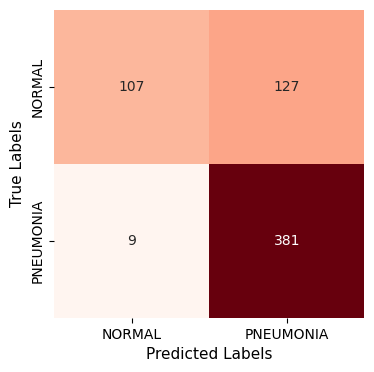

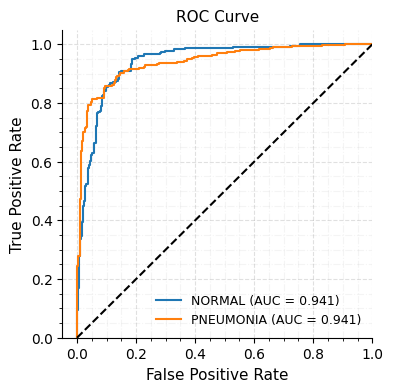

In [20]:
# Evaluate model
accuracy, true_labels, pred_labels, pred_probs = \
    train.evaluate_model(model, dataloaders['test'])

# Plot confusion matrix and ROC curve
cm, _ = train.plot_confusion(true_labels, pred_labels, config);
roc, _ = train.plot_roc(true_labels, pred_probs, config);

# Write results to file
with open(f"data/results/oct-preprocess-{timestamp}.txt", 'w') as f:
    f.write(f"Test accuracy: {accuracy:.3f}%\n")

# Save figures
cm.savefig(f"figures/oct-preprocess-{timestamp}-cm.png")
roc.savefig(f"figures/oct-preprocess-{timestamp}-roc.png")

print(f"Test accuracy: {accuracy:.3f}%")

In [ ]:
# Move files to drive
!mv logs/inception/* "/content/drive/MyDrive/BMES 725 Project/code/logs/inception"
!mv models/* "/content/drive/MyDrive/BMES 725 Project/code/models"
!mv figures/* "/content/drive/MyDrive/BMES 725 Project/code/figures"
!mv results/* "/content/drive/MyDrive/BMES 725 Project/code/results"